# ADA PROJECT - Amazon data

Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

<br>

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

>Features:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


>Features:
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



---

### TO DO LIST

In the followings statements, 'extracted' means filtered with the thema : products/reviews associated to bio/ecology/renewable etc...

- Choose category to focus on : Books ?  / Cinema Movies / Kindle Store / Home Kitchen / Health Personal Care (K) / Tools Home Improvement (K) / Grocery Food  / Tools Home (K)
- Show Proportion of extracted data compared to the full data (of the category)
- Comparison of extracted data between categories (which one contains the most related products/review interest)
- Distribution Price of extracted data (per category) --> Compare between category and with not extracted data in the same category
- Distribution salesRank of extracted data (best per category, mean, proportion of 10% first, 20%first etc...) --> Compare between category and with not extracted data in the same category

- __Keywords__ : How to efficiently implement the selection of related data ? Currently with a list of key words, can use regexp, better writing of keywords etc.. ?

- Associate Metadata with Reviews : __Join__
> - Extract year of 1st review (which will give the publication year of the product -approximately-)
> - Histograms number of extracted products per year 
> - Histograms number of extracted reviews per year
> - Nb of reviews per product per category --> Distribution, compare between categories and with not extracted data to see if reviewers are more inerested/active with our thema products compared to others
> - Helplful note : Compare between categories / Overall
> - Mean rating product : Compare with other products


- __Prediction__
> - Nb of products for following years (Linear Regression)
> - Sentiment Analysis on Reviews (Experiment ?)
> - Prediction overall on price for following years ? (LR)



---
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from datetime import datetime



%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext
import pyspark.sql.functions as sqlf

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<br>



---
### Data collection and preprocessing

<br>

In this part, we will perform the whole data processing.

To simplify what is presented here, we have decided to perform all these steps for each category in **separate pyton scripts**.

<br>

For each category, we will proceed as follows:
- Import the meta data and reviews that have been downloaded as `json` files
- Extract the relevant and writtable features of meta data
- Save it as a parquet file of the form **`\"category\"_datacleaned`**
- We then do the same with the reviews and save a parquet file of the form **`"category\"_reviews`**
- Next, we **filter the data we have to only keep articles related to ecology/bio/renewable etc...**
- Finally, we join the metadata and review dataset using the product ID, and create a finale parquet file of the form **`\"category\"_review_product_join`**

<br>

Therefore, all you need to do now is execute all the scripts to automatically generate all the parquet files that will be used in tis notebook.

>Note that once these files have been created, we can skip this part to gain a lot of time.

<br>

**Grocery and Gourmet Food**

In [ ]:
%run -i "data_collection_grocery_food"
# Run the # Run the data_collection_grocery_food.py file .py file 

**Healthcare**

In [ ]:
%run -i "data_collection_healthcare"

**Patio Lawn and Garden**

In [ ]:
%run -i "data_collection_lawn_garden"

**Books**

In [ ]:
%run -i "data_collection_books"

<br>

Keywords used to filter articles and check if they are eco-friendly:

In [3]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle ", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

<br>

---
### Loading data
<br>

Now that our scripts have generated the files, let's just fetch the data that will allow us to do our analysis.

<br>

**Grocery and Gourmet Food**

In [17]:
grocery_food_datacleaned = spark.read.parquet("meta_Grocery_and_Gourmet_Food.parquet")
grocery_food_reviews = spark.read.parquet("reviews_Grocery_and_Gourmet_Food.parquet")
grocery_food_review_product_join = spark.read.parquet("Grocery_and_Gourmet_Food.parquet")

In [18]:
grocery_filter_products_bio = grocery_food_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Healthcare**

In [6]:
healthcare_datacleaned = spark.read.parquet("meta_HealthPersonalCare.parquet")
healthcare_reviews = spark.read.parquet("reviews_HealthPersonalCare.parquet")
healthcare_review_product_join = spark.read.parquet("HealthPersonalCare_joined.parquet")

In [7]:
healthcare_filter_products_bio = healthcare_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Patio Lawn and Garden**

In [8]:
patiolawn_garden_datacleaned = spark.read.parquet("meta_PatioLawnGarden.parquet")
patiolawn_garden_reviews = spark.read.parquet("reviews_PatioLawnGarden.parquet")
patiolawn_garden_review_product_join = spark.read.parquet("PatioLawnGarden_joined.parquet")

In [9]:
patiolawn_garden_filter_products_bio = patiolawn_garden_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Books**

In [10]:
books_datacleaned = spark.read.parquet("meta_Books.parquet")
books_reviews = spark.read.parquet("reviews_Books.parquet")
books_review_product_join = spark.read.parquet("joined_Books.parquet")

In [21]:
books_filter_products_bio = books_datacleaned.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

<br>

---
### Analysis

<br>

Now let's start analyzing the data we extracted above.

We will carry out different analyses, and each time apply it to all the categories studied to compare them with each other.

<br>

**1)** First, we will compute and visualize **the proportion of environmentally friendly products in each category**. This will allow us to quickly realize the importance of these products in a category. 

This analysis is also important because we have large differences in quantities between the different categories, which could influence the procaine analyses.

<br>

**2)** Then, we will extract the publication dates of each article in each category to **plot the evolution of the number of eco-friendly products**. With these curves, we will then really be able to observe the evolution of the green trend over time.

Of course, we can a priori suspect that we will obtain increasing curves, but it is interesting to evaluate this growth and compare it from one product category to another.

<br>

**3)** Another analysis that we will carry out focuses on the comments left on each of the products. We will indeed track **the distribution of the number of comments by product**. In this way, we can assess people's interest in environmentally friendly products and compare this interest across categories.

<br>


**4)** Then, we will look at the **average prices of the products in a category, and their evolution over time**. In this way, we will be able to observe the price difference between eco-friendly and other products, and to observe the evolution of this difference over time.

<br>

Useful functions:

In [ ]:
books_filter_products_bio = books_datacleaned.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

<br>

#### **1) Proportion of environmentally friendly products in each category**

<br>

**Grocery and Gourmet Food**

In [10]:
print("GROCERY FOOD : Number of products : " + str(grocery_food_datacleaned.rdd.count()) )
print("GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : " + str(grocery_filter_products_bio.count()) )

GROCERY FOOD : Number of products : 145854
GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : 2187


Proportion of extracted data related to ecology/bio/renewable compared to the full data that was available:

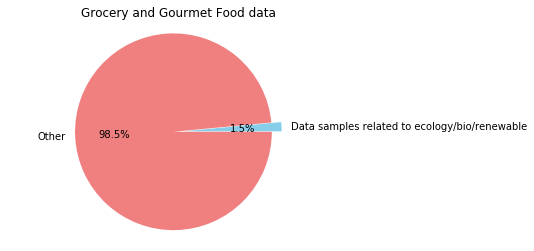

In [12]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([grocery_filter_products_bio.count(), grocery_food_datacleaned.rdd.count()-grocery_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Grocery and Gourmet Food data'); plt.axis('equal'); plt.show()

Let's take a look at one entry that was extracted:

In [14]:
grocery_filter_products_bio.take(1)

[Row(asin='B001EO602S', brand=None, category='Grocery & Gourmet Food', description='The CO2 process delivers a natural, de-caffeinated tea in the purest way possible. Carbon dioxide, acting as a solvent in a super critical state under high-pressure and low temperature, dissolves all active components from natural materials in the leaf. By varying the extraction/separation pressures and temperatures, CO2 makes it possible to selectively extract only the caffeine, leaving the flavor intact. As a solvent, carbon dioxide is non-toxic, odorless, tasteless, germicidal, food-safe and non-combustible and the process does not cause environmental harm.', price=None, salesRank=267957, title='SerendipiTea De-Caff Slim Mint, Chocolate, Vanilla, Rooiboos, Mint &amp; Organic Black Tea, 4-Ounce Boxes (Pack of 2)')]

<br>

**Healthcare**

In [16]:
print("HEALTHCARE : Number of products : " + str(healthcare_datacleaned.rdd.count()) )
print("HEALTHCARE : Number of products related to ecology/bio/renewable etc... : " + str(healthcare_filter_products_bio.count()) )

HEALTHCARE : Number of products : 217977
HEALTHCARE : Number of products related to ecology/bio/renewable etc... : 5390


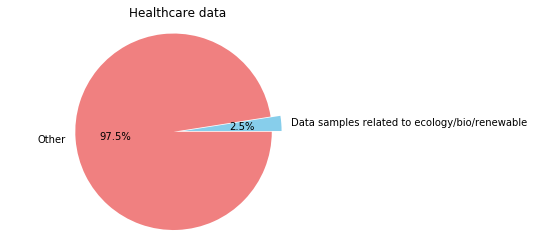

In [17]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([healthcare_filter_products_bio.count(), healthcare_datacleaned.rdd.count()-healthcare_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Healthcare data'); plt.axis('equal'); plt.show()

<br>

**Patio Lawn and Garden**

In [18]:
print("PATIOLAWN - GARDEN : Number of products : " + str(patiolawn_garden_datacleaned.rdd.count()) )
print("PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : " + str(patiolawn_garden_filter_products_bio.count()) )

PATIOLAWN - GARDEN : Number of products : 83455
PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : 3026


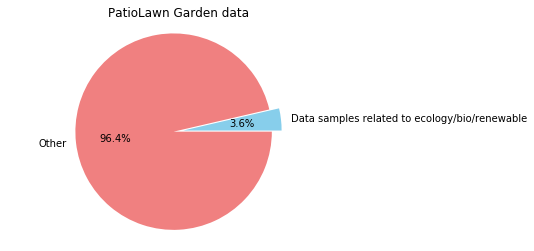

In [19]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([patiolawn_garden_filter_products_bio.count(), patiolawn_garden_datacleaned.rdd.count()-patiolawn_garden_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('PatioLawn Garden data'); plt.axis('equal'); plt.show()

<br>

**Books**

In [22]:
print("BOOKS : Number of products : " + str(books_datacleaned.rdd.count()) )
print("BOOKS : Number of products related to ecology/bio/renewable etc... : " + str(books_filter_products_bio.count()) )

BOOKS : Number of products : 2370585
BOOKS : Number of products related to ecology/bio/renewable etc... : 20723


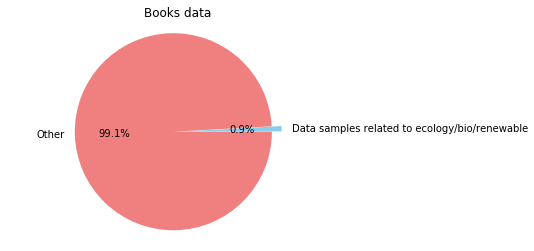

In [23]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([books_filter_products_bio.count(), books_datacleaned.rdd.count()-books_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Books data'); plt.axis('equal'); plt.show()

<br>

#### **2) Evolution of the number of eco-friendly products by year.**

<br>

**Grocery and Gourmet Food**

In [22]:
grocerybio_firstrev = grocery_food_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
grocerybio_firstrev_pd = grocerybio_firstrev.toPandas()
grocerybio_firstrev_pd['Year'] = pd.to_datetime(grocerybio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

groceryall_firstrev = grocery_food_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
groceryall_firstrev_pd = groceryall_firstrev.toPandas()
groceryall_firstrev_pd['Year'] = pd.to_datetime(groceryall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

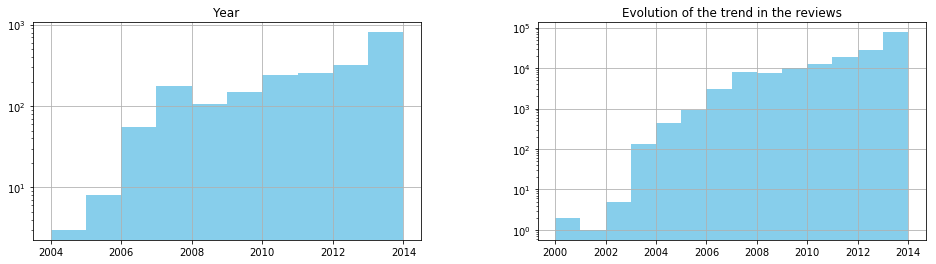

In [23]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


grocerybio_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


groceryall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

<br>

**Healthcare**

In [24]:
healthcarebio_firstrev = healthcare_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcarebio_firstrev_pd = healthcarebio_firstrev.toPandas()
healthcarebio_firstrev_pd['Year'] = pd.to_datetime(healthcarebio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

healthcareall_firstrev = healthcare_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcareall_firstrev_pd = healthcareall_firstrev.toPandas()
healthcareall_firstrev_pd['Year'] = pd.to_datetime(healthcareall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

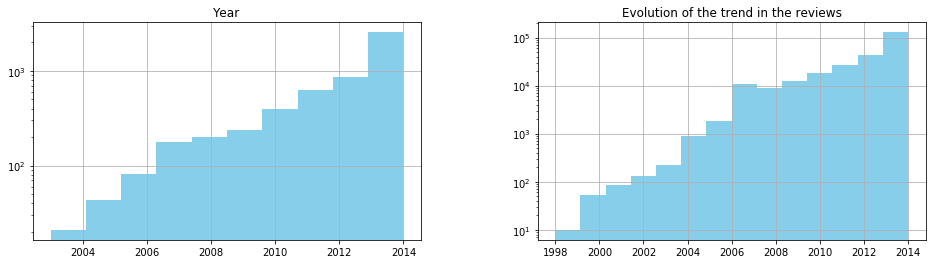

In [25]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


healthcarebio_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


healthcareall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

<br>

**PatioLawn Garden**

In [26]:
gardenbio_firstrev = patiolawn_garden_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardenbio_firstrev_pd = gardenbio_firstrev.toPandas()
gardenbio_firstrev_pd['Year'] = pd.to_datetime(gardenbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

gardeneall_firstrev = patiolawn_garden_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardeneall_firstrev_pd = gardeneall_firstrev.toPandas()
gardeneall_firstrev_pd['Year'] = pd.to_datetime(gardeneall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

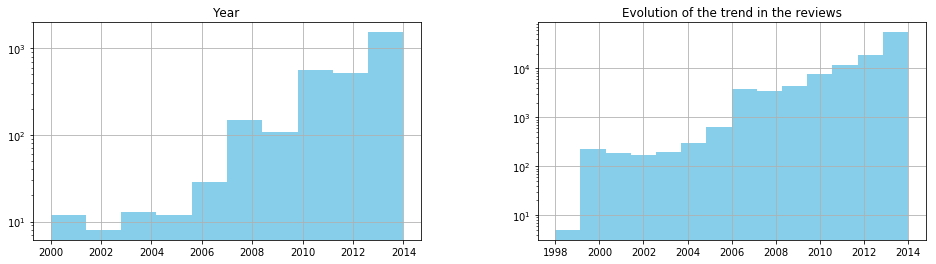

In [27]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


gardenbio_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


gardeneall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

<br>

**Books**

In [24]:
booksbio_firstrev = books_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksbio_firstrev_pd = booksbio_firstrev.toPandas()
booksbio_firstrev_pd['Year'] = pd.to_datetime(booksbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

booksall_firstrev = books_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksall_firstrev_pd = booksall_firstrev.toPandas()
booksall_firstrev_pd['Year'] = pd.to_datetime(booksall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

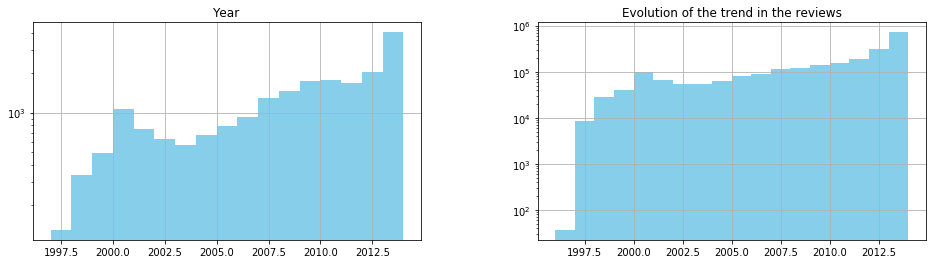

In [25]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


booksbio_firstrev_pd.hist("Year", color="skyblue", log=True,bins=17,ax=axes[0])
plt.title('Evolution of the trend in the products')


booksall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=18, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

<br>

#### **3) Distribution of the number of comments by product**

<br>

**Grocery Food**

In [28]:
grocerybio_nbrev_perproduct=  grocery_food_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [29]:
grocerybio_nbreviews_DF = spark.createDataFrame(grocerybio_nbrev_perproduct, ['productID','freq'])

In [30]:
grocerybio_nbreviews_Pandas = grocerybio_nbreviews_DF.toPandas()

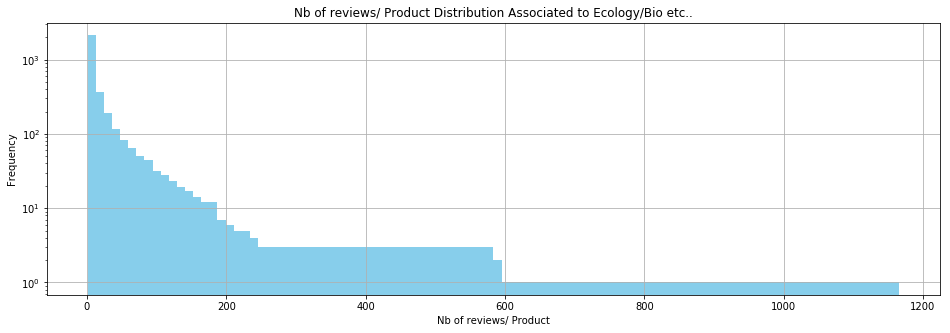

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
grocerybio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

**Healthcare**

In [32]:
healthcarebio_nbrev_perproduct=  healthcare_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [33]:
healthcarebio_nbreviews_DF = spark.createDataFrame(healthcarebio_nbrev_perproduct, ['productID','freq'])

In [34]:
healthcarebio_nbreviews_pd = healthcarebio_nbreviews_DF.toPandas()

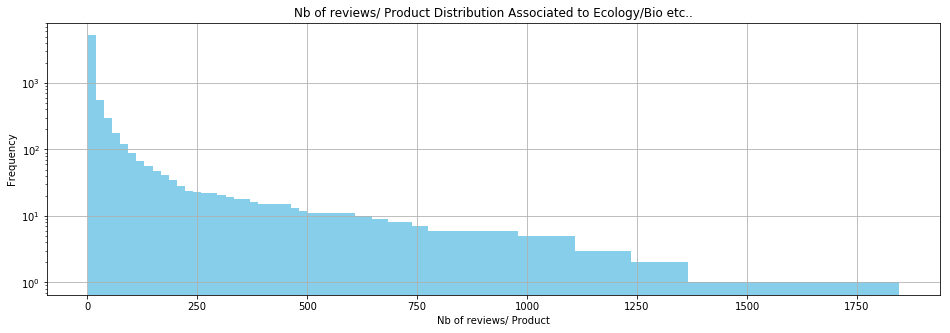

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
healthcarebio_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

**Patio Lawn Garden**

In [36]:
gardenbio_nbrev_perproduct=  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [37]:
gardenbio_nbreviews_DF = spark.createDataFrame(gardenbio_nbrev_perproduct, ['productID','freq'])

In [38]:
gardenbio_nbreviews_pd = gardenbio_nbreviews_DF.toPandas()

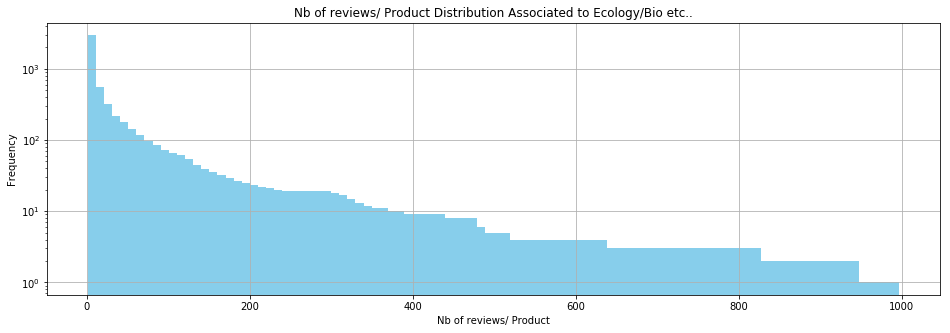

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
gardenbio_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

In [40]:
gardenall_nbrev_perproduct=  patiolawn_garden_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [41]:
gardenall_nbreviews_DF = spark.createDataFrame(gardenall_nbrev_perproduct, ['productID','freq'])

In [42]:
gardenall_nbreviews_pd = gardenall_nbreviews_DF.toPandas()

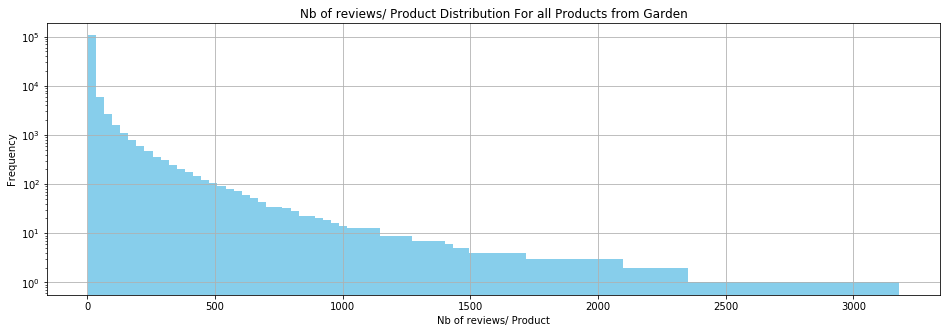

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
gardenall_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution For all Products from Garden")
plt.show()

<br>

**Books**

In [26]:
booksbio_nbrev_perproduct=  books_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [27]:
booksbio_nbreviews_DF = spark.createDataFrame(booksbio_nbrev_perproduct, ['productID','freq'])

In [28]:
booksbio_nbreviews_Pandas = booksbio_nbreviews_DF.toPandas()

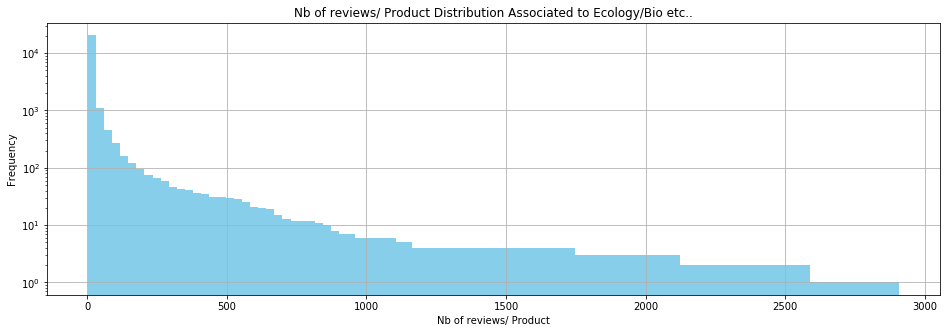

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
booksbio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

####  **4) Price average per year**

**1) Grocery Food**

In [44]:
grocery_products_bio_df = spark.createDataFrame(grocery_filter_products_bio)

grocery_year_join = grocery_products_bio_df.join(grocerybio_firstrev, ['asin'])
grocery_year_join_pd = grocery_year_join.toPandas()

grocery_year_join_pd['Year'] = pd.to_datetime(grocery_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
grocery_year_join_pd = grocery_year_join_pd[np.isfinite(grocery_year_join_pd['price'])]

grocery_year_join_pd = grocery_year_join_pd[['price', 'Year']]

grocery_year_join_pd = grocery_year_join_pd.groupby(['Year']).mean()

grocery_year_join_pd.columns = ['price : Bio products']

In [45]:
grocery_year_join_pd.loc[2000] = 0
grocery_year_join_pd.loc[2002] = 0
grocery_year_join_pd.loc[2003] = 0
grocery_year_join_pd = grocery_year_join_pd.sort_index()

In [46]:
# Mean of price per year of all products from Patio lawn and Garden
grocery_all_year_join = grocery_food_datacleaned.join(groceryall_firstrev, ['asin'])
grocery_all_year_join_pd = grocery_all_year_join.toPandas()

grocery_all_year_join_pd['Year'] = pd.to_datetime(grocery_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

grocery_all_year_join_pd = grocery_all_year_join_pd[np.isfinite(grocery_all_year_join_pd['price'])]
grocery_all_year_join_pd = grocery_all_year_join_pd[['price', 'Year']]

grocery_all_year_join_pd = grocery_all_year_join_pd.groupby(['Year']).mean()

grocery_all_year_join_pd.columns =['price : all products']

Text(0.5,1,'Grocery : Mean price of products per year $')

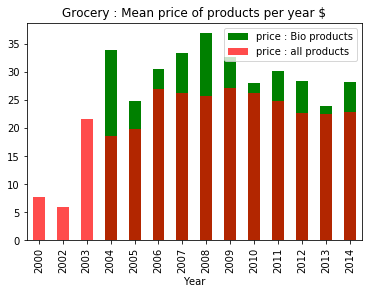

In [47]:
ax = grocery_year_join_pd.plot(kind='bar', color='green')
grocery_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='red')
plt.title('Grocery : Mean price of products per year $')

**2) Healthcare**

In [48]:
healthcare_products_bio_df = spark.createDataFrame(healthcare_filter_products_bio)

healthcarebio_year_join = healthcare_products_bio_df.join(healthcarebio_firstrev, ['asin'])
healthcarebio_year_join_pd = healthcarebio_year_join.toPandas()

healthcarebio_year_join_pd['Year'] = pd.to_datetime(healthcarebio_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcarebio_year_join_pd = healthcarebio_year_join_pd[np.isfinite(healthcarebio_year_join_pd['price'])]

healthcarebio_year_join_pd = healthcarebio_year_join_pd[['price', 'Year']]

healthcarebio_year_join_pd = healthcarebio_year_join_pd.groupby(['Year']).mean()

healthcarebio_year_join_pd.columns = ['price : Bio products']

In [49]:
healthcarebio_year_join_pd.loc[1998] = 0
healthcarebio_year_join_pd.loc[1999] = 0
healthcarebio_year_join_pd.loc[2000] = 0
healthcarebio_year_join_pd.loc[2001] = 0
healthcarebio_year_join_pd.loc[2002] = 0
healthcarebio_year_join_pd = healthcarebio_year_join_pd.sort_index()

In [50]:
# Mean of price per year of all products from Patio lawn and Garden
healthcare_all_year_join = healthcare_datacleaned.join(healthcareall_firstrev, ['asin'])
healthcare_all_year_join_pd = healthcare_all_year_join.toPandas()

healthcare_all_year_join_pd['Year'] = pd.to_datetime(healthcare_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

healthcare_all_year_join_pd = healthcare_all_year_join_pd[np.isfinite(healthcare_all_year_join_pd['price'])]
healthcare_all_year_join_pd = healthcare_all_year_join_pd[['price', 'Year']]

healthcare_all_year_join_pd = healthcare_all_year_join_pd.groupby(['Year']).mean()

healthcare_all_year_join_pd.columns =['price : all products']

Text(0.5,1,'Healthcare : Mean price of products per year $')

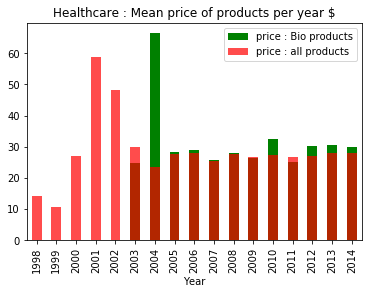

In [51]:
ax = healthcarebio_year_join_pd.plot(kind='bar', color='green')
healthcare_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='red')
plt.title('Healthcare : Mean price of products per year $')

**3) Patio Lawn Garden**

In [52]:
DF_filter_products_bio = spark.createDataFrame(patiolawn_garden_filter_products_bio)

garden_year_join = DF_filter_products_bio.join(gardenbio_firstrev, ['asin'])
garden_year_join_pd = garden_year_join.toPandas()

garden_year_join_pd['Year'] = pd.to_datetime(garden_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
garden_year_join_pd = garden_year_join_pd[np.isfinite(garden_year_join_pd['price'])]

garden_year_join_pd = garden_year_join_pd[['price', 'Year']]

garden_year_join_pd = garden_year_join_pd.groupby(['Year']).mean()

garden_year_join_pd.columns = ['price : Bio products']

In [53]:
# Mean of price per year of all products from Patio lawn and Garden
garden_all_year_join = patiolawn_garden_datacleaned.join(gardeneall_firstrev, ['asin'])
garden_all_year_join_pd = garden_all_year_join.toPandas()

garden_all_year_join_pd['Year'] = pd.to_datetime(garden_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

garden_all_year_join_pd = garden_all_year_join_pd[np.isfinite(garden_all_year_join_pd['price'])]
garden_all_year_join_pd = garden_all_year_join_pd[['price', 'Year']]

garden_all_year_join_pd = garden_all_year_join_pd.groupby(['Year']).mean()

garden_all_year_join_pd.columns =['price : all products']

In [54]:
garden_year_join_pd.loc[1998] = 0
garden_year_join_pd.loc[1999] = 0
garden_year_join_pd = garden_year_join_pd.sort_index()

Text(0.5,1,'Patio Lawn - Garden : Mean price of products per year $')

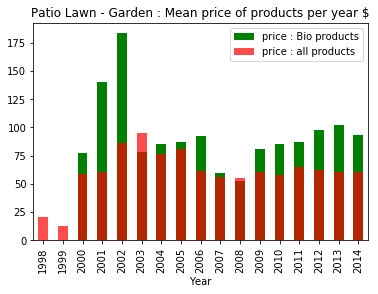

In [55]:
ax = garden_year_join_pd.plot(kind='bar', color='green')
garden_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='red')
plt.title('Patio Lawn - Garden : Mean price of products per year $')

We can see in these graph above that the ecofriendy products are in average more expensive than the global products for each category. However we can not observe a growing trend in the price for these products. 